In [59]:
from google.colab import drive # remove the cell if not using colab
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from matplotlib.colors import ListedColormap
from sklearn.pipeline import Pipeline
from sklearn.tree import plot_tree
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
)

base_path = Path('/content/drive/MyDrive/ml_data')

# Klasyfikacja pasażerów Titanica
Po wysłaniu raportu pozostało już tylko czekać. Dni mijały, ale w końcu telefon zadzwonił. Okazało się, że po konsultacji Twojego raportu z najbardziej doświadczonymi specjalistami w dziedzinie, zleceniodawca zdecydował się powierzyć Ci dalszą część tajemniczego zadania. Chodzi oczywiście o... **stworzenie modelu przewidującego szanse przeżycia katastrofy Titanica**.

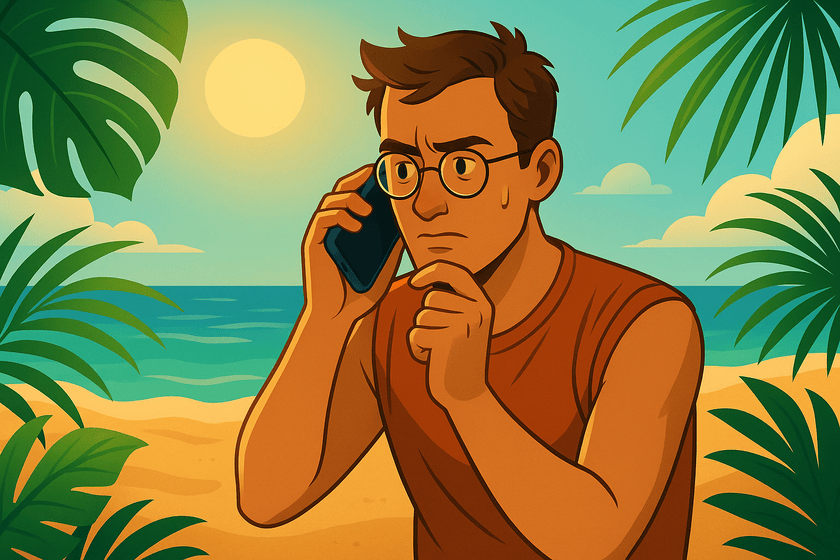

(*AI-generated image*)


#### Twoim celem będzie jest wytrenowanie modeli do klasyfikacji każdego pasażera Titanica jako ofiary (0) lub osoby, która przeżyła (1).

Poniżej znajdziesz pytania, które mogą być pomocne w zadaniu:

- Czego nauczyło Cię o badanym zbiorze danych poprzednie zadanie? Jak możesz wykorzystać wyciągnięte z niego wnioski w procesie tworzenia modelu?
- Jak przeprowadzenie standaryzacji danych może wpływać na zachowanie modelu?
- Co mój model robi i w jaki sposób?
- Jak nie przetrenować wybranego modelu?
- Jaki wynik klasyfikacji możemy uznać za *dobry*?


Wymagania:
- Wypisz obserwacje z pierwszego zadania, które pomogą Ci w tym. Co było przydatne, a co okazało się bezużyteczne?
- [Nie doprowadź](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) do ~~przecieku statku~~ wycieku danych (np. nie ucz modelu na danych testowych). Nauczone modele odpal na danych treningowych i testowych - opisz uzyskane wyniki.
- Stwórz baseline, czyli dla porównania sprawdź jak z zadaniem radzi sobie [Dummy Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html) (jeśli Twój docelowy model radzi sobie gorzej - uciekaj)
- Przeprowadź badania na dwóch wybranych modelach uczenia maszynowego (np. spośród: drzew decyzyjnych, SVM, MLP, KNN, z gwiazdką [XGBoost](https://xgboost.readthedocs.io/en/stable))
- W badaniach użyj wybranych metryk. Wybór uzasadnij.
- Dla każdego modelu wybierz co najmniej dwa hiperparametry i przeprowadź badania zależności wyników metryk od wartości hiperparametrów. Zwizualizuj wszystko ładnie, zastanów się dlaczego tak mogło być i wyciągnij i wypisz wnioski.
- Podsumuj przeprowadzone badania, wypisz wnioski.

Niezmiennie, zadbaj o czytelność kodu i nazewnictwo zmiennych. Jeśli jakiś wycinek kodu się powtarza, to wyodrębnij go do funkcji. Postaraj się zamieszczać swoje wnioski w postaci komentarza `Markdown`.

Jeśli chcesz, możesz sprawdzić (przyjmując pewne założenia), jakie byłyby Twoje szanse na Titanicu.

Uwaga! Jeśli Titanic to dla Ciebie nic i baaaaardzo chcesz to możesz w ramach tego zadania zająć się [bardziej wymagającym](https://archive.ics.uci.edu/dataset/365/polish+companies+bankruptcy+data) zbiorem.

In [61]:
titanic_df = pd.read_csv(base_path / 'titanic.csv', index_col='PassengerId')

In [62]:
titanic_df['Cabin'].str[0].unique()

array([nan, 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

In [63]:
titanic_cleaned_df = pd.read_csv(base_path / "titanic_cleaned.csv")

# 1. Podsumowanie EDA

W pierwszej częsci zadania skupiłam się głównie na tym, żeby dane były czyste i przygotowane do dalszej pracy. Okazało się, że w kilku kolumnach brakowało wartości, np. w wieku, cenie biletu czy porcie, z którego pasażer wsiadał. Uzupełniłam je medianą albo najczęściej występującą wartością, tak żeby nie było dziur. Dzięki temu cały zbiór mogę teraz spokojnie wykorzystać do trenowania modeli.

Przy okazji wyciągnęłam też kilka dodatkowych informacji. Z nazwisk udało mi się zrobić kolumnę z tytułem (np. Mr, Mrs, Miss), która sporo mówi o statusie społecznym. Dodałam też zmienne związane z rodziną – wielkość rodziny i informację, czy ktoś podróżował samotnie. Z numerów kabin wyciągnęłam, na którym pokładzie była dana osoba, a z biletów prefiksy, które czasem wskazują, z jakiej grupy ktoś pochodził.

Z samych danych wynika, że kobiety miały dużo większe szanse przeżycia niż mężczyźni, a pasażerowie z pierwszej klasy ratowali się znacznie częściej niż ci z klas niższych. Widać też, że młodsze osoby oraz ci, którzy mieli droższe bilety, częściej przeżywali. Ciekawostką było to, że osoby podróżujące samotnie miały nieco lepsze wyniki niż duże rodziny.

Niektóre kolumny okazały się raczej bezużyteczne. Id pasażera to tylko numer porządkowy, a pełne nazwiska czy numery biletów nie dają za dużo, bo są unikalne i nic z nich nie wynika. Z kolei pełne numery kabin były zbyt chaotyczne, więc zamiast nich lepiej było zostawić sam pokład.

Podsumowując – mam już dane dobrze oczyszczone i wzbogacone o dodatkowe cechy. Najwięcej informacji niosą płeć, klasa, wiek, cena biletu oraz te nowe zmienne, które dodałam. To właśnie one będą najbardziej przydatne przy budowaniu modeli w kolejnym kroku.

In [64]:
print(titanic_cleaned_df.shape)
print(titanic_cleaned_df['Survived'].value_counts(dropna=False))
titanic_cleaned_df.head(3)

(891, 26)
Survived
0    549
1    342
Name: count, dtype: int64


,Survived,Pclass_ord,Sex_bin,Age,SibSp,Parch,Fare,FamilySize,IsAlone,CabinKnown,...,Title_Other,Title_the Countess,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_U
0,0,3,0,22.0,1,0,7.2500,2,0,0,...,False,False,False,False,False,False,False,False,False,True
1,1,1,1,38.0,1,0,71.2833,2,0,1,...,False,False,False,True,False,False,False,False,False,False
2,1,3,1,26.0,0,0,7.9250,1,1,0,...,False,False,False,False,False,False,False,False,False,True


# 2. Wybór cech i targetu + podział na zbiory

In [65]:
# Target i cechy
y = titanic_cleaned_df["Survived"].astype(int).values
X = titanic_cleaned_df.drop(columns=["Survived"]).copy()

# Podział train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Kształt X_train:", X_train.shape)
print("Kształt X_test :", X_test.shape)

Kształt X_train: (712, 25)
Kształt X_test : (179, 25)


# 2. Funkcje pomocnicze

In [66]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred_tr = model.predict(X_train)
    y_pred_te = model.predict(X_test)

    def safe_auc(m, X, y_true):
        try:
            proba = m.predict_proba(X)[:,1]
            return roc_auc_score(y_true, proba)
        except:
            return np.nan

    return {
        "train": {
            "accuracy": accuracy_score(y_train, y_pred_tr),
            "precision": precision_score(y_train, y_pred_tr, zero_division=0),
            "recall": recall_score(y_train, y_pred_tr, zero_division=0),
            "f1": f1_score(y_train, y_pred_tr, zero_division=0),
            "roc_auc": safe_auc(model, X_train, y_train)
        },
        "test": {
            "accuracy": accuracy_score(y_test, y_pred_te),
            "precision": precision_score(y_test, y_pred_te, zero_division=0),
            "recall": recall_score(y_test, y_pred_te, zero_division=0),
            "f1": f1_score(y_test, y_pred_te, zero_division=0),
            "roc_auc": safe_auc(model, X_test, y_test)
        }
    }, y_pred_te

def plot_cm(y_true, y_pred, title):
    fig, ax = plt.subplots(figsize=(4,4))
    disp = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred))
    disp.plot(ax=ax, colorbar=False)
    ax.set_title(title)
    plt.show()

# 3. Baseline — Dummy Classifier

In [67]:
dummy_mf = DummyClassifier(strategy="most_frequent")
dummy_str = DummyClassifier(strategy="stratified", random_state=42)

mf_metrics, _ = evaluate_model(dummy_mf, X_train, y_train, X_test, y_test)
str_metrics, _ = evaluate_model(dummy_str, X_train, y_train, X_test, y_test)

print("Dummy (most frequent) — TEST:", mf_metrics["test"])
print("Dummy (stratified)    — TEST:", str_metrics["test"])


Dummy (most frequent) — TEST: {'accuracy': 0.6145251396648045, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'roc_auc': np.float64(0.5)}
Dummy (stratified)    — TEST: {'accuracy': 0.5195530726256983, 'precision': 0.36507936507936506, 'recall': 0.3333333333333333, 'f1': 0.3484848484848485, 'roc_auc': np.float64(0.4848484848484848)}


# 4. Modele docelowe

Drzewo decyzyjne

Decision Tree — TEST: {'accuracy': 0.7374301675977654, 'precision': 0.6410256410256411, 'recall': 0.7246376811594203, 'f1': 0.6802721088435374, 'roc_auc': np.float64(0.7240447957839262)}


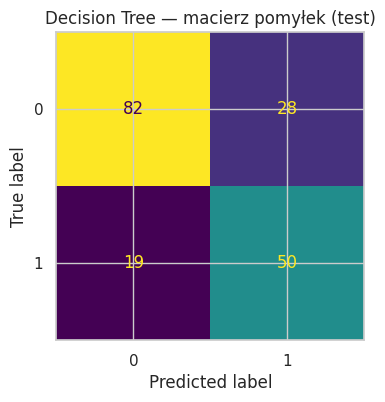

In [68]:
tree = DecisionTreeClassifier(random_state=42)
tree_metrics, tree_pred = evaluate_model(tree, X_train, y_train, X_test, y_test)

print("Decision Tree — TEST:", tree_metrics["test"])
plot_cm(y_test, tree_pred, "Decision Tree — macierz pomyłek (test)")

KNN (ze standaryzacją)

KNN — TEST: {'accuracy': 0.7821229050279329, 'precision': 0.7142857142857143, 'recall': 0.7246376811594203, 'f1': 0.7194244604316546, 'roc_auc': np.float64(0.8289855072463768)}


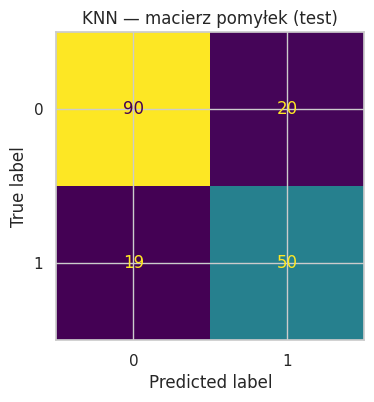

In [69]:
knn = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", KNeighborsClassifier())
])
knn_metrics, knn_pred = evaluate_model(knn, X_train, y_train, X_test, y_test)

print("KNN — TEST:", knn_metrics["test"])
plot_cm(y_test, knn_pred, "KNN — macierz pomyłek (test)")


# 5. Badanie hiperparametrów

Do oceny jakości modeli wykorzystałam kilka metryk: accuracy, precision, recall, F1-score oraz AUC. Accuracy pozwala ogólnie określić, jak wiele przypadków zostało poprawnie sklasyfikowanych, jednak w przypadku niezbalansowanych klas może być mylące. Dlatego zdecydowałam się dodatkowo stosować precision i recall, które opisują odpowiednio poprawność klasyfikacji klasy pozytywnej oraz jej kompletność. F1-score stanowi kompromis pomiędzy precision i recall, dlatego był głównym kryterium wyboru najlepszych hiperparametrów w walidacji krzyżowej. Wreszcie AUC pozwala ocenić jakość modelu niezależnie od progu klasyfikacji i daje pełniejszy obraz jego możliwości. Taki zestaw metryk zapewnia bardziej rzetelną ocenę modeli niż samo accuracy.

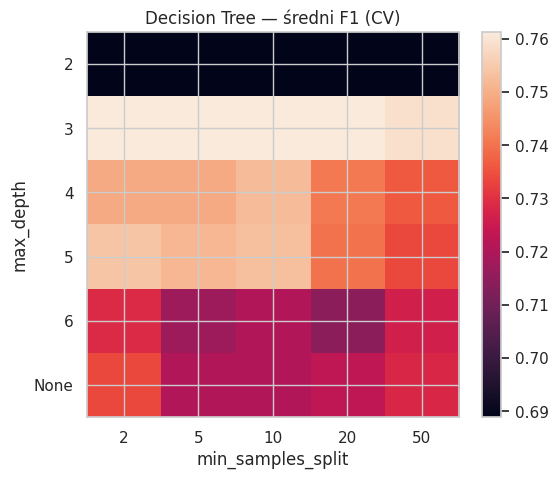

In [70]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
depths = [2, 3, 4, 5, 6, None]
min_splits = [2, 5, 10, 20, 50]

scores_tree = np.zeros((len(depths), len(min_splits)))
for i, d in enumerate(depths):
    for j, mss in enumerate(min_splits):
        model = DecisionTreeClassifier(max_depth=d, min_samples_split=mss, random_state=42)
        res = cross_validate(model, X_train, y_train, scoring="f1", cv=cv)
        scores_tree[i,j] = res["test_score"].mean()

plt.figure(figsize=(6,5))
plt.imshow(scores_tree, aspect="auto")
plt.xticks(range(len(min_splits)), min_splits)
plt.yticks(range(len(depths)), [str(d) for d in depths])
plt.xlabel("min_samples_split")
plt.ylabel("max_depth")
plt.title("Decision Tree — średni F1 (CV)")
plt.colorbar()
plt.show()


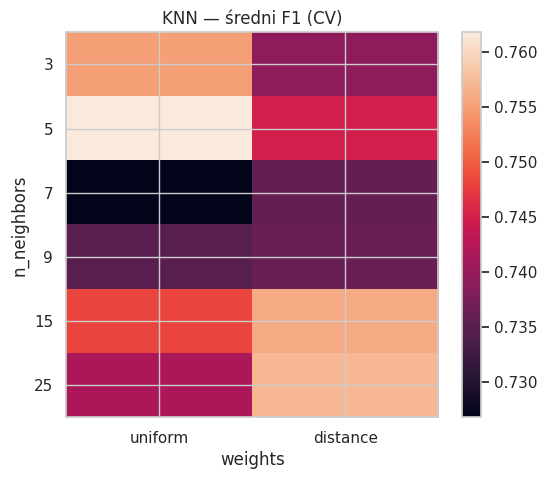

In [71]:
k_values = [3,5,7,9,15,25]
weights_list = ["uniform", "distance"]

scores_knn = np.zeros((len(k_values), len(weights_list)))
for i,k in enumerate(k_values):
    for j,w in enumerate(weights_list):
        model = Pipeline([
            ("scaler", StandardScaler()),
            ("clf", KNeighborsClassifier(n_neighbors=k, weights=w))
        ])
        res = cross_validate(model, X_train, y_train, scoring="f1", cv=cv)
        scores_knn[i,j] = res["test_score"].mean()

plt.figure(figsize=(6,5))
plt.imshow(scores_knn, aspect="auto")
plt.xticks(range(len(weights_list)), weights_list)
plt.yticks(range(len(k_values)), k_values)
plt.xlabel("weights")
plt.ylabel("n_neighbors")
plt.title("KNN — średni F1 (CV)")
plt.colorbar()
plt.show()


# 6. Najlepsze modele

Best Decision Tree — TEST: {'accuracy': 0.8268156424581006, 'precision': 0.7878787878787878, 'recall': 0.7536231884057971, 'f1': 0.7703703703703704, 'roc_auc': np.float64(0.863965744400527)}


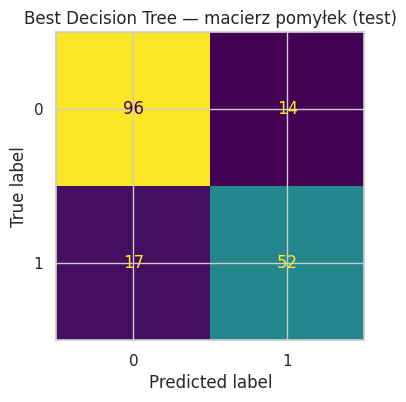

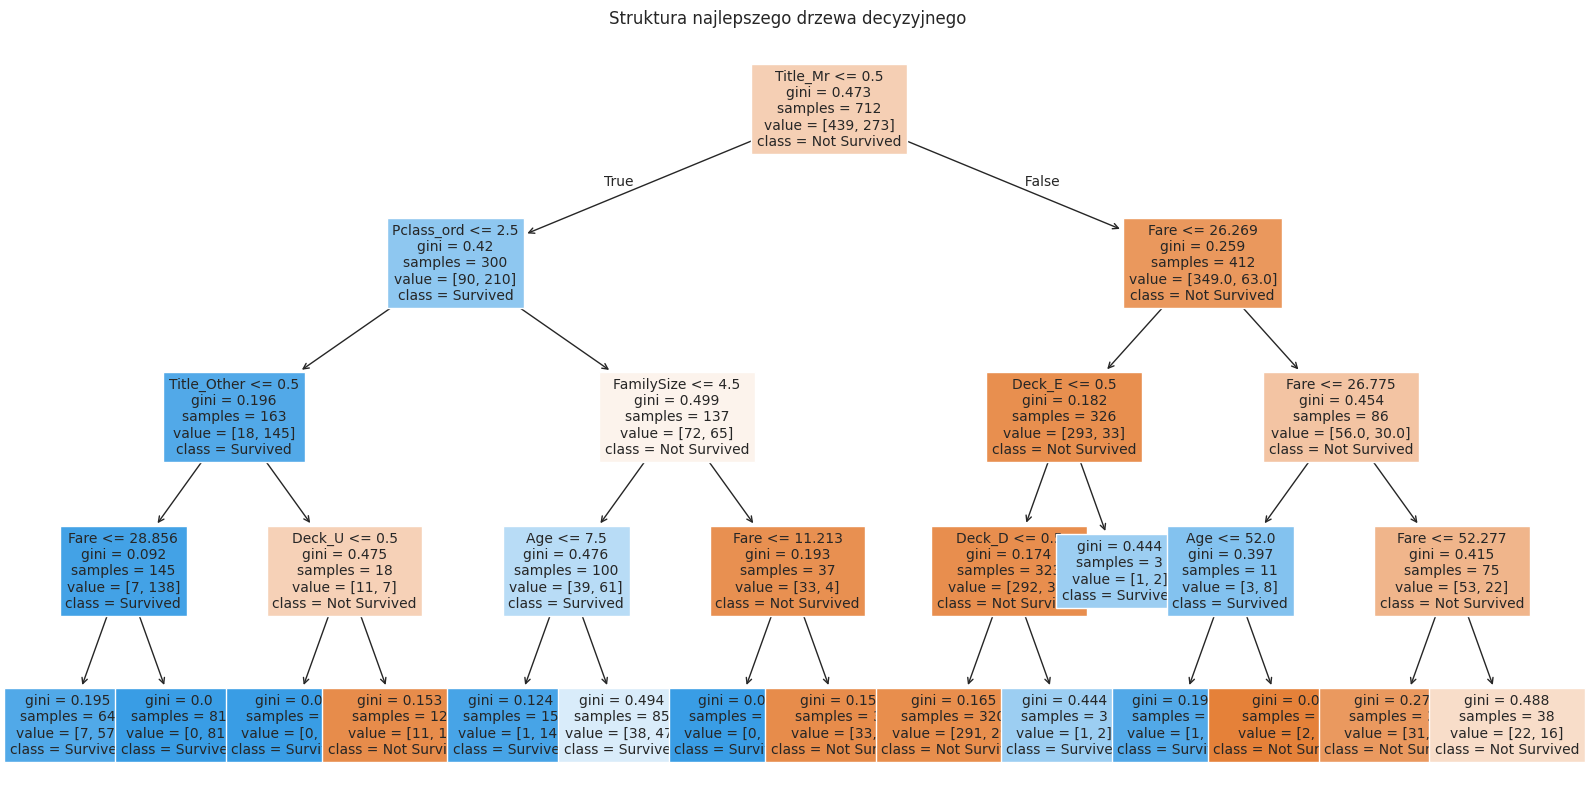

In [72]:
best_tree = DecisionTreeClassifier(max_depth=4, min_samples_split=10, random_state=42)
best_tree_metrics, best_tree_pred = evaluate_model(best_tree, X_train, y_train, X_test, y_test)

# Wyświetlenie metryk
print("Best Decision Tree — TEST:", best_tree_metrics["test"])

# Wyświetlenie macierzy pomyłek
plot_cm(y_test, best_tree_pred, "Best Decision Tree — macierz pomyłek (test)")

# Wyświetlenie samego drzewa
plt.figure(figsize=(20,10))
plot_tree(
    best_tree,
    feature_names=X.columns,
    class_names=["Not Survived","Survived"],
    filled=True,
    fontsize=10
)
plt.title("Struktura najlepszego drzewa decyzyjnego")
plt.show()

W przypadku drzewa decyzyjnego początkowy model osiągnął na zbiorze testowym accuracy na poziomie około 0.74 i F1 w okolicach 0.68. Był to wynik lepszy niż baseline, ale pozostawiał przestrzeń do poprawy. Dlatego przeprowadziłam strojenie hiperparametrów, badając zależność jakości klasyfikacji od wartości max_depth oraz min_samples_split. Do oceny posłużyłam się walidacją krzyżową i metryką F1, dzięki czemu mogłam sprawdzić, jak zmienia się równowaga między precision i recall w zależności od stopnia złożoności drzewa.

Analiza pokazała, że zbyt płytkie drzewa nie były w stanie dobrze uchwycić zależności w danych, natomiast zbyt głębokie miały tendencję do przeuczenia. Najlepsze wyniki uzyskałam dla konfiguracji max_depth = 4 i min_samples_split = 10. Model w tej wersji osiągnął na zbiorze testowym accuracy około 0.83 oraz F1 na poziomie 0.77, co oznacza wyraźną poprawę względem wersji domyślnej. Dodatkowo wizualizacja struktury drzewa pozwala łatwo zinterpretować, jakie cechy odgrywają kluczową rolę w klasyfikacji – wśród nich najważniejsze okazały się m.in. płeć, wiek i klasa pasażera.

Best KNN — TEST: {'accuracy': 0.7430167597765364, 'precision': 0.6493506493506493, 'recall': 0.7246376811594203, 'f1': 0.684931506849315, 'roc_auc': np.float64(0.8173254281949935)}


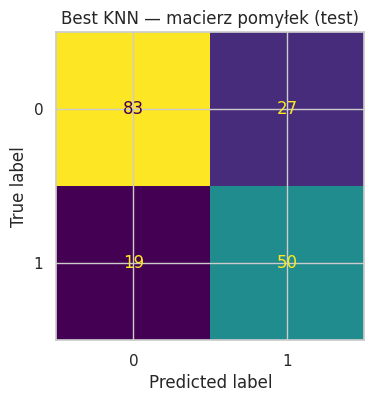

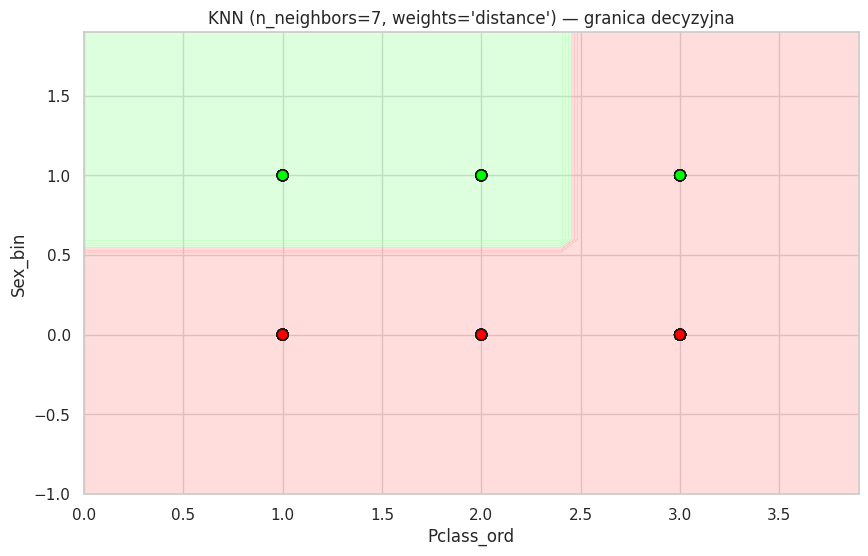

In [73]:
best_k = 7
best_weight = "distance"

# pipeline z najlepszymi hiperparametrami
best_knn = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", KNeighborsClassifier(n_neighbors=best_k, weights=best_weight))
])
best_knn_metrics, best_knn_pred = evaluate_model(best_knn, X_train, y_train, X_test, y_test)

print("Best KNN — TEST:", best_knn_metrics["test"])
plot_cm(y_test, best_knn_pred, "Best KNN — macierz pomyłek (test)")

# wybór 2 cech do wizualizacji
features_to_plot = X.columns[:2]
X_train_2d = X_train[features_to_plot].values
X_test_2d = X_test[features_to_plot].values

# osobny pipeline tylko dla 2D
knn_2d = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", KNeighborsClassifier(n_neighbors=best_k, weights=best_weight))
])
knn_2d.fit(X_train_2d, y_train)

h = 0.1
x_min, x_max = X_train_2d[:, 0].min() - 1, X_train_2d[:, 0].max() + 1
y_min, y_max = X_train_2d[:, 1].min() - 1, X_train_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = knn_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00'])

plt.figure(figsize=(10,6))
plt.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.4)
plt.scatter(X_test_2d[:,0], X_test_2d[:,1], c=y_test, cmap=cmap_bold, edgecolor='k', s=60)
plt.xlabel(features_to_plot[0])
plt.ylabel(features_to_plot[1])
plt.title(f"KNN (n_neighbors={best_k}, weights='{best_weight}') — granica decyzyjna")
plt.show()


W przypadku klasyfikatora KNN uzyskałam dość ciekawe wyniki. Początkowy model, zbudowany z domyślnymi ustawieniami, osiągnął na zbiorze testowym accuracy na poziomie około 0.78 i F1 w okolicach 0.72. Był to bardzo solidny wynik, lepszy niż baseline. Następnie przeprowadziłam strojenie hiperparametrów, badając różne wartości liczby sąsiadów oraz sposób ważenia. Jako kryterium wyboru najlepszego modelu przyjęłam F1-score w walidacji krzyżowej, ponieważ ta metryka lepiej odzwierciedla równowagę pomiędzy precision i recall w sytuacji, gdy klasy nie są idealnie zbalansowane. Na tej podstawie wybrałam model z parametrami n_neighbors = 7 i weights = "distance". Ten wariant – nazwany jako „best KNN” – na zbiorze testowym uzyskał accuracy na poziomie 0.74 oraz F1 na poziomie 0.68.

Na pierwszy rzut oka może wydawać się to niespójne, ponieważ wersja domyślna KNN miała wyższe accuracy. Różnica wynika jednak z przyjętego kryterium optymalizacji – „best KNN” został wybrany ze względu na lepsze wyniki F1 w walidacji krzyżowej, a nie najwyższe accuracy. Oznacza to, że ten model lepiej balansuje pomiędzy wykrywaniem osób, które przeżyły, a tymi, które nie przeżyły, choć kosztem spadku ogólnej liczby poprawnych klasyfikacji. W praktyce wybór najlepszego modelu zależy więc od tego, którą metrykę uznajemy za ważniejszą: jeśli kluczowe jest ogólne accuracy, można preferować wariant domyślny; jeśli zaś istotniejsza jest równowaga między precision i recall, lepszym rozwiązaniem będzie model wybrany według F1.

# 7. Podsumowanie


Podsumowując przeprowadzone eksperymenty, oba modele – drzewo decyzyjne i KNN – poradziły sobie znacznie lepiej niż klasyfikatory bazowe. Wersja najlepszego drzewa decyzyjnego osiągnęła accuracy na poziomie około 0.83 i F1 = 0.77, co stanowi najlepszy wynik spośród wszystkich przetestowanych modeli. Z kolei najlepszy KNN uzyskał accuracy około 0.74 i F1 = 0.68. Choć KNN sprawdził się całkiem nieźle, szczególnie pod kątem AUC (0.82), to jednak drzewo decyzyjne okazało się skuteczniejsze i bardziej stabilne. Dodatkową zaletą drzewa jest jego interpretowalność – łatwo wskazać cechy najbardziej wpływające na decyzję modelu.

Wnioskiem końcowym jest więc to, że w tym zadaniu lepiej sprawdziło się drzewo decyzyjne, które daje zarówno wyższą skuteczność predykcji, jak i większą przejrzystość w analizie cech decydujących o przeżyciu pasażerów Titanica.